In [1]:
!pip install -U jaxlib[cuda112]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!apt-get -y install swig
!pip install smac
!pip install graphviz
!pip install gplearn

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 MB 14.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.17-py3-none-any.whl size=1217849 sha256=d8d573c234ee675ff3a428db10799c67ff80246aa52e2278e094b14ccbd81a5f
  Stored in directory: /root/.cache/pip/wheels/36/cd/88/2d90379f7549c27d5654e893f74210f30f0c645c23a71e6f56
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

In [11]:
if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
# tfd = tfp.distributions
import jax
import jax.numpy as jnp
import haiku as hk
import numpy as np
import optax
from nn_util import *
plt.style.use('ggplot')
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Load Cell Line Data

In [13]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_data = pd.read_csv(f"{gdsc_dir}/gdsc_gene_expr.csv", index_col="model_id")
gdsc_exp_data.shape

(442, 37263)

In [14]:
gdsc_response_data = pd.read_csv(f"{gdsc_dir}/GDSC2_fitted_dose_response_24Jul22.csv", index_col="SANGER_MODEL_ID")
gdsc_response_data

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,
SIDM01132,GDSC2,401,18945558,683667,PFSK-1,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-1.462148,0.930105,0.088999,0.432482
SIDM00848,GDSC2,401,18945796,684052,A673,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-4.869447,0.614932,0.111423,-1.420322
SIDM00263,GDSC2,401,18946078,684057,ES5,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.360684,0.790953,0.142754,-0.599894
SIDM00269,GDSC2,401,18946335,684059,ES7,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-5.045014,0.592624,0.135642,-1.515791
SIDM00203,GDSC2,401,18946617,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.741620,0.733992,0.128066,-0.807038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00216,GDSC2,401,19187490,1659928,SNU-175,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.134495,0.976798,0.074441,0.159946
SIDM00214,GDSC2,401,19187943,1660034,SNU-407,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,8.575555,0.913182,0.057743,-1.626059
SIDM00194,GDSC2,401,19188201,1660035,SNU-61,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.520666,0.974889,0.058094,0.602364


#### Tamoxifen

In [15]:
tamox_response_data = gdsc_response_data[gdsc_response_data["DRUG_NAME"] == "Tamoxifen"]
tamox_response_data.shape

(957, 18)

In [16]:
gdsc_exp_tamox_data = pd.merge(gdsc_exp_data, tamox_response_data["LN_IC50"], left_index=True, right_index=True)
gdsc_exp_tamox_data.shape

(406, 37264)

In [17]:
X, y = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
y = -np.log10(np.exp(y)) # exp b/c the values are natural logs of raw IC_50

In [18]:
cancer_driver_genes = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
cancer_driver_genes

,symbol,method_of_action,cosmic_moa,intogen_moa,gene_id
0,ABCB1,Act,NaN,Act,SIDG00064
1,ABI1,ambiguous,"TSG, fusion",ambiguous,SIDG00145
2,ABL1,Act,"oncogene, fusion",Act,SIDG00150
3,ABL2,Act,"oncogene, fusion",Act,SIDG00151
4,ACKR3,Act,"oncogene, fusion",Act,SIDG00205
...,...,...,...,...,...
778,ZNF814,Act,NaN,Act,SIDG42334
779,ZNF93,LoF,NaN,LoF,SIDG41755
780,ZNRF3,LoF,NaN,LoF,SIDG42403
781,ZRSR2,LoF,TSG,LoF,SIDG42422


In [19]:
cancer_genes = list(set(X.columns) & set(cancer_driver_genes["symbol"]))
X_selected = X[cancer_genes]
X_selected.shape

(406, 768)

In [20]:
from sklearn.preprocessing import StandardScaler

seed = 775

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_selected, y, random_state=seed, shuffle=True, test_size=0.2)

In [21]:
train_scaler = StandardScaler().fit(X_train_df)
train_scaled = train_scaler.transform(X_train_df)
test_scaled = train_scaler.transform(X_test_df)

X_train_df = pd.DataFrame(train_scaled, columns=X_train_df.columns)
X_test_df = pd.DataFrame(test_scaled, columns=X_test_df.columns)

In [22]:
X_train_df = pd.DataFrame(train_scaled, columns=X_train_df.columns)
X_test_df = pd.DataFrame(test_scaled, columns=X_test_df.columns)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, random_state=seed, 
                                                        shuffle=True, test_size=0.3)
X_train_df.shape

(226, 768)

In [23]:
X_train, y_train = X_train_df.to_numpy(), y_train_df.to_numpy()
X_test, y_test = X_test_df.to_numpy(), y_test_df.to_numpy()

In [24]:
gene_names = [col.strip() for col in X_train_df.columns]

### Interaction Data

In [25]:
string_ppi = pd.read_csv(f"{data_dir}/cell_line/string_ppi.csv")
string_ppi

,symbolA,symbolB,weight
0,ARF5,ACAP2,0.767
1,ARF5,RAB1A,0.730
2,ARF5,COPE,0.745
3,ARF5,ACAP1,0.765
4,ARF5,COPZ1,0.757
...,...,...,...
474973,EIF3L,EIF3K,0.999
474974,EIF3L,EIF4G1,0.908
474975,EIF3L,EIF3E,0.999
474976,EIF3L,RPL22,0.738


In [26]:
len(gene_names)

768

In [27]:
# %autoreload
# from nn_util import build_network_string
# J = build_network_string(gene_names, string_ppi)
# np.count_nonzero(J)

In [28]:
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
np.count_nonzero(J)

11862

In [29]:
%autoreload
from operator import itemgetter
from tqdm import tqdm

def evaluate_bnn(model, X, y, params, gammas):
    eval_fn = lambda p, g: model.apply(p, X, g).ravel()
    preds = jax.vmap(eval_fn)(params, gammas)
    preds = preds.reshape(-1, preds.shape[-1])
    losses = jax.vmap(optax.l2_loss, in_axes=(0, None))(preds, y)
    mean_loss = jnp.mean(losses, axis=-1)
    return jnp.sum(mean_loss)

def get_feats_dropout_loss(sgmcmc, X, y):
    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    
    disc_states = mixed_sgmcmc.states_.discrete_position
    contin_states = mixed_sgmcmc.states_.contin_position
    
    

    num_models = disc_states.shape[0]

    p = X.shape[1]

    for idx in range(p):
        # idx = feats_idx[i]
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            disc_states_on = disc_states[idx_on]
            params_on = jax.tree_util.tree_map(lambda x: x[idx_on], contin_states)
            loss_on = evaluate_bnn(sgmcmc.model_, X, y, params_on, disc_states_on)

            # Turn-off the variable, and see hwo the loss changes
            disc_states_off = disc_states_on.at[:,idx].set(0)
            loss_off = evaluate_bnn(sgmcmc.model_, X, y, params_on, disc_states_off)

            loss_diff = (loss_on - loss_off) * (len(idx_on) / num_models)


        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

def get_gene_names(gene_cols):
    return [gene.split("(")[0].strip() for gene in gene_cols]

### BNN

In [30]:
%autoreload
from smac.facade.smac_mf_facade import SMAC4MF
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sgmcmc_cyclical_bkp import MixedSGMCMC
from run_nn_fisher_test_exp import run_logistic_regression
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration

import math

def get_configspace(input_size)-> ConfigurationSpace:
    # Build Configuration Space which defines all parameters and their ranges.

    layer_dims = [50, 100, 150, 200, 250, 300, 350]

    cs  = ConfigurationSpace()

    # layer_dim = CategoricalHyperparameter("layer_dim", layer_dims, default_value=layer_dims[0])
    activation = CategoricalHyperparameter("activation", ["relu", "tanh"], default_value="tanh")
    
    disc_lr = CategoricalHyperparameter("disc_lr", [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5] , default_value=1e-1)
    contin_lr = CategoricalHyperparameter("contin_lr", [1e-5, 1e-4, 1e-3, 1e-2], default_value=1e-5) #TODO Extend range

    # lr_schedule = CategoricalHyperparameter("lr_schedule", ["cyclical"], default_value="cyclical")
    num_cycles = CategoricalHyperparameter("num_cycles", [3, 4, 5, 7], default_value=5)
    beta = CategoricalHyperparameter("beta", [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], default_value=0.9)

    # batch_size = CategoricalHyperparameter("batch_size", [16, 32, 64, 128], default_value=32)
    # thinning_interval = CategoricalHyperparameter("thinning_interval", [10, 50, 100, 150, 200], default_value=100)

    # eta = CategoricalHyperparameter("eta", [0.01, 0.1, 1., 5, 10., 50., 100.], default_value=1.)
    mu = CategoricalHyperparameter("mu", [0.01, 0.1, 1., 5, 10., 50., 100.], default_value=1.)
    temp = CategoricalHyperparameter("temp", [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.], default_value=1.)
    sigma = CategoricalHyperparameter("sigma", [1e-3, 1e-2, 1e-1, 0.5, 1., 10.], default_value=1.)


    # Add hyper-parameters
    cs.add_hyperparameters([activation, disc_lr, contin_lr, mu, temp, sigma, beta])
    # cs.add_hyperparameters([mu])

    # # Cyclical SG-MCMC condition
    # use_cycle_len = InCondition(child=cycle_len, parent=lr_schedule, values=["cyclical"])
    # use_beta = InCondition(child=beta, parent=lr_schedule, values=["cyclical"])
    #
    # cs.add_conditions([use_cycle_len, use_beta])

    return cs

def get_cv_score(model, X, y, cv, activation_fns, J):

    scores = []

    for train_idx, test_idx in cv.split(X, y):
        x_train_cv, y_train_cv = X[train_idx], y[train_idx]
        x_test_cv, y_test_cv = X[test_idx], y[test_idx]
        model.fit(x_train_cv, y_train_cv, activation_fns=activation_fns, J=J)
        score = jax.device_get(model.score(x_test_cv, y_test_cv))
        scores.append(score)
    
    mean_score = np.mean(np.array(scores))
    if math.isnan(mean_score):
        return -1e9
    
    return mean_score

def generate_train_cs(seed, X, y, J):
    cv = KFold(n_splits=3, shuffle=True, random_state=seed)
    # X_tr, X_val, y_tr, y_val = train_test_split(X, y, stratify=y, test_size=0.1, shuffle=seed)
    def train_cs(config: Configuration)-> float:

        params = {"disc_lr":config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": 32,
                  "mu": config["mu"], "eta": 1.0, "temp": config["temp"],
                  "sigma": config["sigma"], "beta": config["beta"], "num_cycles": 5}

        # params = {"disc_lr": 0.1, "contin_lr": 1e-5, "batch_size": 20,
        #           "mu": config["mu"], "eta": 1.0, "temp": 1.0,
        #           "sigma": 1.0, "beta": 0.95, "num_cycles": 5}

        # print(config)
        mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=200, n_warmup=0, lr_schedule="cyclical",
                                    layer_dims=[400, 300, 100], classifier=False ,**params)

        score = get_cv_score(mixed_sgmcmc, X, y, cv, [config["activation"], config["activation"], config["activation"]], J)
        # print(score)
        return 1 - score


    return train_cs


def optimize_hyper_parameters(seed, X, y, J, total_time=60):
    cs = get_configspace(X.shape[1])
    scenario = Scenario({
        "run_obj": "quality",
        "wallclock-limit": total_time,
        "cs": cs,
        "deterministic": True,
        "cutoff": 10,  # runtime limit for the target algorithm
        "verbose_level": "DEBUG", 
        "seed": seed
    })

    max_steps = 5000

    train_cs = generate_train_cs(seed, X, y, J)

    intensifier_kwargs = {"initial_budget": 2000, "max_budget": max_steps}

    # smac = SMAC4MF(scenario=scenario, rng=np.random.RandomState(seed),
    #                tae_runner=train_cs, intensifier_kwargs=intensifier_kwargs)

    smac = SMAC4HPO(scenario=scenario, rng=np.random.RandomState(seed), tae_runner=train_cs)

    tae = smac.get_tae_runner()

    try:
        incumbent = smac.optimize()

    finally:
        incumbent = smac.solver.incumbent


    inc_val = tae.run(config=incumbent, budget=max_steps, seed=seed)

    return incumbent, 1 - inc_val[1]


In [54]:
# config, score = optimize_hyper_parameters(seed, X_train, y_train, J, total_time=300)
# score

2022-11-30 15:20:46.997469: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 300.00MiB (314572800B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  300.00MiB
              constant allocation:         0B
        maybe_live_out allocation:  300.00MiB
     preallocated temp allocation:         0B
                 total allocation:  600.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 300.00MiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=0]" source_file="/notebooks/tree_utils.py" source_line=178
		XLA Label: concatenate
		Shape: f32[256,768,400]

	Buffer 2:
		Size: 18.75MiB
		Entry Parameter Subshape: f32[16,768,400]

	Buffer 3:
		Size: 18.75MiB
		Entry Parameter Subshape: f32[16,768,400]

	Buffer 4:
		Size: 18.75MiB
		Entry Parameter

: 

In [31]:
config = {
  'activation': 'tanh',
  'beta': 0.90,
  'contin_lr': 1e-5,
  'disc_lr': 0.001,
  'eta': 1.0,
  'mu': 1.0,
  'sigma': 1.0,
  'temp': 1.0,
}

In [32]:
%autoreload
from sgmcmc_cyclical_bkp import MixedSGMCMC
from sklearn.metrics import r2_score
cv = KFold(n_splits=3, shuffle=True, random_state=seed)
params = {"disc_lr":config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": 32,
                  "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
                  "sigma": config["sigma"], "beta": config["beta"], "num_cycles": 5}

mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=100, n_warmup=0, lr_schedule="cyclical",
                            layer_dims=[300, 100], classifier=False ,**params)

# cv_score_bnn = get_cv_score(mixed_sgmcmc, X_train_sig, y_train, cv, config["activation_fns"], J)
# print(cv_score_bnn)
mixed_sgmcmc.fit(X_train, y_train, activation_fns=["relu"] , J=J)
n_models = mixed_sgmcmc.states_.discrete_position.shape[0]
print(f"Num models: {n_models}")
print(f"test_score: {mixed_sgmcmc.score(X_test, y_test)}")

2022-12-01 16:22:43.395999: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 487.50MiB (511180800B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  487.50MiB
              constant allocation:         0B
        maybe_live_out allocation:  487.50MiB
     preallocated temp allocation:         0B
                 total allocation:  975.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 487.50MiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=0]" source_file="/notebooks/tree_utils.py" source_line=178
		XLA Label: concatenate
		Shape: f32[208,768,800]

	Buffer 2:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]

	Buffer 3:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]

	Buffer 4:
		Size: 37.50MiB
		Entry Parameter

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 487.50MiB (511180800B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  487.50MiB
              constant allocation:         0B
        maybe_live_out allocation:  487.50MiB
     preallocated temp allocation:         0B
                 total allocation:  975.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 487.50MiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=0]" source_file="/notebooks/tree_utils.py" source_line=178
		XLA Label: concatenate
		Shape: f32[208,768,800]
		==========================

	Buffer 2:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 3:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 4:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 5:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 6:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 7:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 8:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 9:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 10:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 11:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 12:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 13:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================

	Buffer 14:
		Size: 37.50MiB
		Entry Parameter Subshape: f32[16,768,800]
		==========================



In [64]:
%autoreload
from gibbs_sampler_cyclical_bkp import *
from nn_models import *
disc_logprior_fn = generate_disc_logprior_fn(J, config["mu"], config["eta"], config["temp"])
contin_logprior_fn = generate_contin_logprior_fn(config["sigma"], config["temp"])
log_ll_fn = make_gaussian_likelihood(config["sigma"], config["temp"], X_train.shape[0])

In [93]:

log_ll_fn(mixed_sgmcmc.model_, contin_pos, [X_train, y_train], disc_pos)

(DeviceArray(-0.5793755, dtype=float32),
 DeviceArray([ 3.325289  ,  1.3569763 ,  3.9624488 ,  5.126395  ,
               5.0288014 ,  1.1789916 ,  1.8843458 ,  1.2986592 ,
               0.14187036,  2.7664676 ,  4.1776967 ,  4.354251  ,
               3.9846854 ,  3.1764054 ,  3.2539606 ,  4.0630555 ,
               2.5592132 ,  7.8799405 ,  3.6811771 ,  0.39229938,
               2.874559  ,  3.1386042 ,  4.4332466 ,  1.9259742 ,
               0.86165994,  5.2674828 ,  0.29588765,  1.9810389 ,
               7.1189327 ,  5.4239845 ,  2.3757286 ,  1.8636016 ,
               5.238155  ,  0.7995595 ,  0.79229647,  2.2837548 ,
               2.4337616 ,  1.028684  ,  0.6879557 ,  0.5541406 ,
               1.0129316 ,  4.274734  ,  1.4592621 ,  1.0597363 ,
               0.79880494,  2.669365  ,  1.1404643 ,  4.3138433 ,
               0.70505804,  2.7612405 ,  3.0075426 ,  6.1055617 ,
               3.750311  ,  1.2408602 ,  2.9639528 ,  4.8589306 ,
               9.72441   ,  0.59230

DeviceArray(182463.14, dtype=float32)

In [34]:
mixed_sgmcmc.exp_states.contin_logprob

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [37]:
stats.pearsonr(y_test, mixed_sgmcmc.predict(X_test))

ValueError: array must not contain infs or NaNs

In [48]:
disc_per_cycle = mixed_sgmcmc.states_.discrete_position.reshape(mixed_sgmcmc.num_cycles, -1, mixed_sgmcmc.states_.discrete_position.shape[-1])
contin_per_cycle = jax.tree_util.tree_map(lambda x: x.reshape((mixed_sgmcmc.num_cycles, -1) + x.shape[1:]), mixed_sgmcmc.states_.contin_position)

In [61]:
from gibbs_sampler_cyclical_bkp import make_gaussian_likelihood

log_ll = make_gaussian_likelihood(mixed_sgmcmc.sigma, mixed_sgmcmc.temp, X_train_sig.shape[0])

per_cycle_ll = jax.vmap(jax.vmap(lambda p, g: log_ll(mixed_sgmcmc.model_, p, [X_train_sig, y_train], g)))(contin_per_cycle, disc_per_cycle)

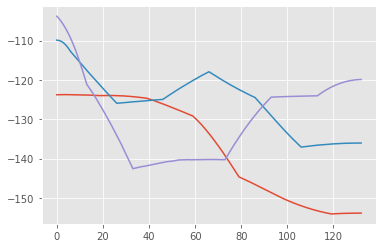

In [62]:
for i in range(mixed_sgmcmc.num_cycles):
    plt.plot(per_cycle_ll[i])

In [63]:
from scipy import stats

hmean = 1./(jnp.sum(1/per_cycle_ll, axis=-1)/per_cycle_ll.shape[-1])
hmean

DeviceArray([-136.03757, -125.16908, -128.7287 ], dtype=float32)

In [64]:
pred_fn = lambda p, g: mixed_sgmcmc.model_.apply(p, X_train_sig, g).ravel()

per_cycle_pred = jax.vmap(jax.vmap(pred_fn))(contin_per_cycle, disc_per_cycle)

In [49]:
dropout_loss = get_feats_dropout_loss(mixed_sgmcmc, X_train_sig, y_train)
dropout_loss

,feats_idx,num_models,loss_on,loss_off,loss_diff
100,100,50,1452333.2,1452557.6,-224.375
64,64,50,1452333.2,1452422.8,-89.5
67,67,50,1452333.2,1452417.0,-83.75
82,82,50,1452333.2,1452404.2,-71.0
41,41,50,1452333.2,1452399.9,-66.625
...,...,...,...,...,...
72,72,50,1452333.2,1452247.2,86.0
99,99,50,1452333.2,1452235.8,97.5
90,90,50,1452333.2,1452218.8,114.5
76,76,50,1452333.2,1452212.0,121.25


In [50]:
bnn_feat_idx = dropout_loss["feats_idx"][:20].to_list()
bnn_gene_list = X_train_sig_df.iloc[:,bnn_feat_idx].columns.to_list()
bnn_gene_list = get_gene_names(bnn_gene_list)
bnn_gene_list

['ESR1',
 'INHBB',
 'GPRC5C',
 'KRT15',
 'KRT80',
 'KRT8',
 'KRT18',
 'CUEDC1',
 'S100A10',
 'TPBG',
 'WFDC3',
 'ARHGEF28',
 'ABCC3',
 'S100A11',
 'TUFT1',
 'AHNAK2',
 'LRRC8E',
 'TM4SF1',
 'TNFRSF12A',
 'GNG12']

In [33]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9)
grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 1, scoring="explained_variance").fit(X_train, y_train)

rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9,**grid_cv.best_params_)
rf_reg.fit(X_train, y_train)
y_test_pred_rf = rf_reg.predict(X_test)
print(f"RF params: {grid_cv.best_params_}")
print(f"cv score: {grid_cv.best_score_}, test_score:  {r2_score(y_test, y_test_pred_rf)}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits


2022-11-30 15:02:36.314463: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:190] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 16900227072
2022-11-30 15:02:36.508867: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:190] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 16900227072
2022-11-30 15:02:36.568897: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:190] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory

RF params: {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
cv score: 0.24886105920299037, test_score:  0.26936704281143586


In [34]:
stats.pearsonr(y_test, rf_reg.predict(X_test))

(0.5520994714048856, 7.580750109139147e-08)

In [36]:
rf_feat_idx = np.argsort(rf_reg.feature_importances_)[::-1][:20]
rf_gene_list = X_train_df.iloc[:,rf_feat_idx].columns.to_list()
rf_gene_list = get_gene_names(rf_gene_list)
rf_gene_list

['IKZF1',
 'HSPG2',
 'RHPN2',
 'TFAP4',
 'SMARCA1',
 'ARID1A',
 'MSH6',
 'GNAQ',
 'RGL3',
 'EGFR',
 'GNA11',
 'CNTRL',
 'FLI1',
 'LMNA',
 'LOX',
 'WWTR1',
 'SETD2',
 'VHL',
 'FSTL3',
 'ARHGEF10L']

### GP

In [38]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier, SymbolicRegressor
from gplearn.functions import make_function
import operator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

def get_best_programs(gp, num_models, classifier=True, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': [], "Equation": []}

    if classifier:
        for idGen in range(len(gp._programs)):
            for idPopulation in range(gp.population_size):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)
                gp_dict["Equation"].append(str(gp._programs[idGen][idPopulation]))
    else:
        for idx, prog in enumerate(gp._programs[-1]):
                gp_dict["Gen"].append(-1)
                gp_dict["Ind"].append(idx)
                gp_dict["Fitness"].append(prog.fitness_)
                gp_dict["OOB_fitness"].append(prog.oob_fitness_)
                gp_dict["Equation"].append(str(prog))

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs, gp_df


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier or (sort_fit == "OOB_fitness"):
        programs, gp_df = get_best_programs(est, num_models, classifier, sort_fit=sort_fit, ascending=classifier)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out, gp_df
    else:
        return est.transform(X), None

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']

def train_gp(feats_idx, X_train, X_val, X_test, y_train, y_val, y_test, num_models=5, sort_fit="OOB_fitness"):
    X_gp_train, X_gp_val, X_gp_test = X_val[:,feats_idx], X_train[:,feats_idx], X_test[:,feats_idx]
    gp_est = SymbolicTransformer(population_size=1000, hall_of_fame=100, n_components=20, generations=100,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.8, verbose=0,
                           parsimony_coefficient=0.005, random_state=seed)

    gp_est.fit(X_gp_train, y_val)
    gp_features_val, gp_val_df = gp_transform(gp_est, X_gp_val, classifier=False, sort_fit=sort_fit, num_models=num_models)
    gp_features_test, gp_test_df = gp_transform(gp_est, X_gp_test, classifier=False, sort_fit=sort_fit, num_models=num_models)

    X_val_comb, X_test_comb = np.concatenate([X_gp_val, gp_features_val], axis=1),\
                             np.concatenate([X_gp_test, gp_features_test], axis=1)

    param_grid = {"alpha":np.logspace(-2, 2, 20)}
    grid_cv = GridSearchCV(estimator=Ridge(max_iter=10000), param_grid=param_grid, 
                                            verbose=0, scoring="explained_variance", cv=cv).fit(X_val_comb, y_train)
    lin_model = Ridge(max_iter=10000, **grid_cv.best_params_)
    cv_score = grid_cv.best_score_
    lin_model.fit(X_val_comb, y_train)
    y_test_pred = lin_model.predict(X_test_comb)
    test_score = r2_score(y_test, y_test_pred)
    test_pearson, pval = stats.pearsonr(y_test, y_test_pred)
    return cv_score, test_score, test_pearson, pval

#### BNN Selected Features

In [55]:
cv_score, test_score, test_pc, pc_pval = train_gp(bnn_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                    y_train, y_val, y_test, num_models=1)

print(f"cv_score: {cv_score}, test_score: {test_score},\nPearson Corr: {test_pc}, pvalue: {pc_pval}")

cv_score: -0.2119184646386674, test_score: 0.06639932000486792,
Pearson Corr: 0.30425614450499644, pvalue: 0.0010515269643341033


#### RF Selected Features

In [39]:
cv_score, test_score, test_pc, pc_pval = train_gp(rf_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                    y_train, y_val, y_test, num_models=1)

print(f"cv_score: {cv_score}, test_score: {test_score},\nPearson Corr: {test_pc}, pvalue: {pc_pval}")

NameError: name 'X_train_sig' is not defined

### Multiple Runs

In [50]:
# seeds = [422,261,968,282,739]
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]

In [51]:
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import pickle 
from datetime import timedelta
import time

save_dir = f"{data_dir}/exp_data_5/cancer/ccle"

bnn_exp_dict = {"seed": [], "model": [], "cv_score": [], "test_score": []}
bnn_gp_dict = {"seed": [], "model": [], "num_feats": [], "n_models": [], "cv_score": [], "test_score": [], "test_pearson": [], "pvalue": []}

num_feats = 20 # TODO this should be selected by CV
n_models = 5 # TODO this should be selected by CV

for seed in seeds:
    print(f"Running seed: {seed}")

    start = time.time()

    cv = KFold(n_splits=5, shuffle=True, random_state=seed)

    ## TODO Wrap this in a function
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)
    
    train_df, test_df = pd.concat([X_train_df, y_train_df], axis=1),\
                                     pd.concat([X_test_df, y_test_df], axis=1)


    train_scaler = StandardScaler().fit(train_df)
    train_scaled = train_scaler.transform(train_df)

    test_scaler = StandardScaler().fit(test_df)
    test_scaled = test_scaler.transform(test_df)

    X_train_df, y_train_df = pd.DataFrame(train_scaled[:,:-1], columns=X_train_df.columns), pd.Series(train_scaled[:,-1])
    X_test_df, y_test_df = pd.DataFrame(test_scaled[:,:-1], columns=X_test_df.columns), pd.Series(test_scaled[:,-1])

    X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, random_state=seed, 
                                                        shuffle=True, test_size=0.3)

    sig_genes_idx = calculate_sig_genes(X_train_df, y_train_df)
    sig_genes_idx = sig_genes_idx[:500]

    target_gene_idx = [i for i, col in enumerate(X_train_df.columns) if target_gene in col]
    X_train_sig_df = pd.concat([X_train_df.iloc[:,sig_genes_idx], X_train_df.iloc[:,target_gene_idx]], axis=1)
    X_val_sig_df = pd.concat([X_val_df.iloc[:,sig_genes_idx], X_val_df.iloc[:,target_gene_idx]], axis=1)
    X_test_sig_df = pd.concat([X_test_df.iloc[:,sig_genes_idx], X_test_df.iloc[:,target_gene_idx]], axis=1)

    gene_names = [col.split("(")[0].strip() for col in X_train_sig_df.columns]
   
    J = build_network_string(gene_names, string_ppi)

    X_train_sig, X_val_sig, X_test_sig = X_train_sig_df.to_numpy(), X_val_sig_df.to_numpy(), X_test_sig_df.to_numpy()
    y_train, y_test, y_val = y_train_df.to_numpy(), y_test_df.to_numpy(), y_val_df.to_numpy()
    X_train_sig, X_test_sig, y_train, y_test = jax.device_put(X_train_sig), jax.device_put(X_test_sig), \
                                    jax.device_put(y_train), jax.device_put(y_test)

    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9)
    grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid, 
                            cv = cv, n_jobs = -1, verbose = 0, scoring="explained_variance").fit(X_train_sig, y_train)

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9, **grid_cv.best_params_)
    rf_reg.fit(X_train_sig, y_train)
    rf_val_score = r2_score(y_val, rf_reg.predict(X_val_sig))
    rf_test_score = r2_score(y_test,  rf_reg.predict(X_test_sig))

    # config, bnn_cv_score, _ = optimize_hyper_parameters(seed, X_train_sig, y_train, J, total_time=180)
    # config = pickle.load(open(f"{save_dir_100}/bnn_params_s_{seed}.pickle", "rb"))

    params = {"disc_lr":config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": X_train_sig.shape[0],
                    "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
                    "sigma": config["sigma"], "beta": config["beta"], "num_cycles": config["num_cycles"]}

    mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=1000, n_warmup=0, lr_schedule="cyclical",
                            layer_dims=config["layer_dim"], classifier=False ,**params)

    mixed_sgmcmc.fit(X_train_sig, y_train, activation_fns=config["activation_fns"] , J=J)

    bnn_val_score = mixed_sgmcmc.score(X_val_sig, y_val)
    bnn_test_score = mixed_sgmcmc.score(X_test_sig, y_test)

    dropout_loss = get_feats_dropout_loss(mixed_sgmcmc, X_train_sig, y_train)
    dropout_loss.to_csv(f"{save_dir}/drop_out_loss_s_{seed}.csv", index=False)


    bnn_exp_dict["seed"].append(seed)
    bnn_exp_dict["model"].append("RF")
    bnn_exp_dict["cv_score"].append(rf_val_score)
    bnn_exp_dict["test_score"].append(rf_test_score)

    bnn_exp_dict["seed"].append(seed)
    bnn_exp_dict["model"].append("BNN")
    bnn_exp_dict["cv_score"].append(bnn_val_score)
    bnn_exp_dict["test_score"].append(bnn_test_score)
    

    
    print(f"RF cv_score: {rf_val_score}, RF test_score: {rf_test_score}")
    print(f"BNN cv_score: {bnn_val_score}, BNN test_score: {bnn_test_score}")
    print("=================== GP Train ======================")

    bnn_feat_idx = dropout_loss["feats_idx"][:num_feats].to_list()
    rf_feat_idx = np.argsort(rf_reg.feature_importances_)[::-1][:num_feats]
    bnn_gp_cv_score, bnn_gp_test_score, bnn_gp_test_pc, bnn_gp_pc_pval = train_gp(bnn_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                                                    y_train, y_val, y_test, num_models=n_models)

    rf_gp_cv_score, rf_gp_test_score, rf_gp_test_pc, rf_gp_pc_pval = train_gp(rf_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                                                    y_train, y_val, y_test, num_models=n_models)
    bnn_gp_dict["seed"].append(seed)
    bnn_gp_dict["model"].append("RF")
    bnn_gp_dict["num_feats"].append(num_feats)
    bnn_gp_dict["n_models"].append(n_models)
    bnn_gp_dict["cv_score"].append(rf_gp_cv_score)
    bnn_gp_dict["test_score"].append(rf_gp_test_score)
    bnn_gp_dict["test_pearson"].append(rf_gp_test_pc)
    bnn_gp_dict["pvalue"].append(rf_gp_pc_pval)

    bnn_gp_dict["seed"].append(seed)
    bnn_gp_dict["model"].append("BNN")
    bnn_gp_dict["num_feats"].append(num_feats)
    bnn_gp_dict["n_models"].append(n_models)
    bnn_gp_dict["cv_score"].append(bnn_gp_cv_score)
    bnn_gp_dict["test_score"].append(bnn_gp_test_score)
    bnn_gp_dict["test_pearson"].append(bnn_gp_test_pc)
    bnn_gp_dict["pvalue"].append(bnn_gp_pc_pval)

    end = time.time()
    elapsed = timedelta(seconds=(end - start))

    print(f"BNN GP - cv_score: {bnn_gp_cv_score}, test_score: {bnn_gp_test_score}, Pearson Corr: {bnn_gp_test_pc}, pvalue: {bnn_gp_pc_pval}")
    print(f"RF GP - cv_score: {rf_gp_cv_score}, test_score: {rf_gp_test_score}, Pearson Corr: {rf_gp_test_pc}, pvalue: {rf_gp_pc_pval}")
    print(f"Done - seed {seed}, Elpased time: {elapsed}")
    print("============================")

bnn_exp_df = pd.DataFrame(bnn_exp_dict)
bnn_exp_df.to_csv(f"{save_dir}/res_bnn_exp_summary.csv", index=False)
bnn_gp_df = pd.DataFrame(bnn_gp_dict)
bnn_gp_df.to_csv(f"{save_dir}/res_bnn_gp_summary.csv", index=False)

Running seed: 422
Num batches: 1
RF cv_score: 0.07444513100837169, RF test_score: 0.14340958099649903
BNN cv_score: 0.05867323303143723, BNN test_score: 0.04118898890076794
=================== GP Train ======================
BNN GP - cv_score: 0.004919826697642948, test_score: 0.13149002422509182, Pearson Corr: 0.3701427883774948, pvalue: 5.455307892371551e-05
RF GP - cv_score: -0.30814202885863556, test_score: 0.12099939913504965, Pearson Corr: 0.3495700529689586, pvalue: 0.0001475716901833638
Done - seed 422, Elpased time: 0:08:09.180125
Running seed: 261
Num batches: 1
RF cv_score: 0.11352835269504746, RF test_score: 0.11687619049433673
BNN cv_score: 0.045516233310539445, BNN test_score: 0.05277284450093633
=================== GP Train ======================
BNN GP - cv_score: -0.040481192025634535, test_score: 0.10632144072383776, Pearson Corr: 0.3269483778793585, pvalue: 0.00040851481955343137
RF GP - cv_score: -0.13186501374314913, test_score: 0.08880894418216034, Pearson Corr: 0

In [70]:
save_dir = f"{data_dir}/exp_data_5/cancer/ccle"
bnn_exp_df = pd.read_csv(f"{save_dir}/res_bnn_exp_summary.csv")
bnn_exp_df.groupby(["model"])[["cv_score", "test_score"]].mean()

,cv_score,test_score
model,,
BNN,0.019391,0.026616
RF,0.070922,0.080446


In [71]:
bnn_gp_df = pd.read_csv(f"{save_dir}/res_bnn_gp_summary.csv")
bnn_gp_df.groupby(["model"])["cv_score", "test_score", "test_pearson", "pvalue"].mean()

,cv_score,test_score,test_pearson,pvalue
model,,,,
BNN,-1.333401,-0.347569,0.210509,0.108245
RF,-55.886796,-0.560879,0.160347,0.244877


In [72]:
bnn_exp_df

,seed,model,cv_score,test_score
0,422,RF,0.074445,0.143410
1,422,BNN,0.058673,0.041189
2,261,RF,0.113528,0.116876
3,261,BNN,0.045516,0.052773
4,968,RF,0.080619,0.104856
5,968,BNN,0.055292,0.018350
6,282,RF,0.064128,0.068582
7,282,BNN,-0.041115,-0.033087
8,739,RF,0.062723,0.045962
9,739,BNN,0.031394,0.018562


In [43]:
bnn_gp_df

,seed,model,num_feats,n_models,cv_score,test_score,test_pearson,pvalue
0,422,RF,20,5,-0.308142,0.120999,0.349570,0.000148
1,422,BNN,20,5,0.004920,0.131490,0.370143,0.000055
2,261,RF,20,5,-0.131865,0.088809,0.303835,0.001069
3,261,BNN,20,5,-0.040481,0.106321,0.326948,0.000409
4,968,RF,20,5,-2.670991,0.019450,0.229813,0.014339
5,968,BNN,20,5,-3.959822,0.049970,0.232787,0.013093
6,282,RF,20,5,0.040376,-0.392828,0.068487,0.471044
7,282,BNN,20,5,-15.927015,0.013091,0.180645,0.055529
8,739,RF,20,5,0.105556,-0.108618,0.064467,0.497528
9,739,BNN,20,5,0.053136,-0.104863,0.142622,0.131824


In [ ]:
import torch
from itertools import product

data_dim, num_cls = 2, 3

zeros_mat = torch.zeros((1, data_dim, num_cls)) 

classes = [i for i in range(num_cls)]
probs = []
combos = list(product(classes, repeat=data_dim))

In [50]:
combos

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [48]:
rand_mat = torch.rand_like(zeros_mat)
rand_mat

tensor([[[0.9672, 0.6902, 0.1459],
         [0.0576, 0.8922, 0.0325]]])

In [51]:
rand_mat[:, :, combos[1]]

tensor([[[0.9672, 0.6902],
         [0.0576, 0.8922]]])

In [85]:
dist = tfd.Categorical(probs=[[0.1, 0.5, 0.4], [0.1, 0.5, 0.4]])
x_cur  = dist.sample(seed=rng_key, sample_shape=(2,))
x_cur

DeviceArray([[1, 2],
             [1, 1]], dtype=int32)

In [86]:
x_cur_oh = jax.nn.one_hot(x_cur, 3)
x_cur_oh.shape

(2, 2, 3)

In [87]:
grad = jax.random.normal(rng_key, x_cur_oh.shape)
grad

DeviceArray([[[ 0.3708746 , -1.1752596 , -0.51433975],
              [ 1.9475722 , -1.298365  , -0.61030054]],

             [[ 0.5575748 ,  0.10283418, -0.8314232 ],
              [-0.37285715, -0.54886764, -0.5990561 ]]], dtype=float32)

In [84]:
grad.shape

(1, 2, 3)

In [91]:
grad_cur = grad[0, :, x_cur[0, :]]
grad_cur

DeviceArray([[-1.1752596 , -1.298365  ],
             [-0.51433975, -0.61030054]], dtype=float32)

In [94]:
grad_cur.shape

(2, 2)

In [105]:
jnp.tile(grad_cur[:,:,None], (1, 1, 2))

DeviceArray([[[-1.1752596 , -1.1752596 ],
              [-1.298365  , -1.298365  ]],

             [[-0.51433975, -0.51433975],
              [-0.61030054, -0.61030054]]], dtype=float32)

In [89]:
grad[1, :, x_cur[1, :]]

DeviceArray([[ 0.10283418, -0.54886764],
             [ 0.10283418, -0.54886764]], dtype=float32)

In [88]:
x_cur[1, :]

DeviceArray([1, 1], dtype=int32)